In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from PIL import Image

# Pacifist Game Jam Design Doc

### Name(s)
* Healing
* Wind & Rain
* Njǫrd (norse god of wind)

### Premise
You are the god of the wind [, and rain]. Reforest your tortured world. Try your best to abate disasters, and spread life across your lands

### Environment and Game Loop
The game begins with a desolate land devoid of life aside from a small oasis. Your goal is to spread life through solely the power of the wind **[and rain]**. The game is controlled from the first person perspective from a sort of 'flying' view. You can switch between controlling wind **[and rain]**.

Once plants mature they will produce seeds if the conditions are favorable. The seeds will be visible and can be 'blown' by the wind, released and carried. When airborn seeds intersect the ground, they will start growing.

Conflict will arise as randomly spawned wild fires. When a fire starts the player will be able to try to influence it, through their power **[to produce rain, and]** to direct the wind.

The player's magnitude of their powers, and frequency of naturally ocurring rainfall is directly related to the amount of plant life in the world. As a result the power of fires will scale to attempt to counter the player.

_square braces denote stretch goals_

### Player Scaling and Opposition Balance

In [2]:
# The following function models the number of individual plants as a function of the radius that the player has populated
def plants(r):
    density = 1
    return density * np.pi * pow(r, 2)

The units of 'power' used below should be units of world area per second. Meaning amount of world the fires can burn per second, and the amount of world the player can reforest per second 

In [3]:
# In the game, the players power will be a function of the number of plants.
def power(r):
    # c = 2 pi r
    # a = pi r^2
    # sqrt(a / pi) = r
    r = np.sqrt(plants(r) / np.pi)
    
    some_scaling_factor = 0.01
    return r * some_scaling_factor

In [4]:
# The power of spawning wild fires will lag the player's power.
def wildfire_power(last_fire_p, last_fire_i, player_p):
    p = 0.5
    i = 0.25
    d = 0.5
    
    delta = player_p - last_fire_p
    last_fire_i += delta
    
    # implement the wildfire's power as a PID controller
    return p * player_p + i * last_fire_i + d * delta, last_fire_i

In [5]:
def sim(rs):
    powers = [power(plants(r)) for r in rs]
    wildfire_powers = []
    last_fire_p = 0
    last_fire_p_i = 0
    for p in powers:
        wildfire_powers += [last_fire_p]
        last_fire_p, last_fire_p_i = wildfire_power(last_fire_p, last_fire_p_i, p)
        
    return powers, wildfire_powers

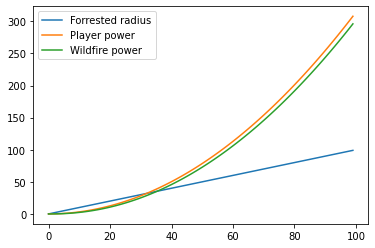

In [6]:
rs = [r for r in range(100)]
powers, wildfire_powers = sim(rs)

plt.plot(rs, label='Forrested radius')
plt.plot(powers, label='Player power')
plt.plot(wildfire_powers, label='Wildfire power')
plt.legend()
plt.show()

The power of fires will always be closely behind the heels of the player. Lets see what it looks like if the player's power grows but ocsillates.

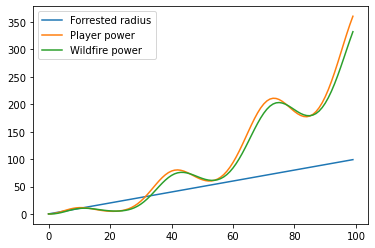

In [7]:
powers, wildfire_powers = sim([max(0, t + 10 * np.sin(t / 5)) for t in range(100)])

plt.plot(rs, label='Forrested radius')
plt.plot(powers, label='Player power')
plt.plot(wildfire_powers, label='Wildfire power')
plt.legend()
plt.show()

### Controls

When controlling the wind, the player's camera moves quickly as a wind gust itself. When controlling the rain, the player moves much slower, and is forced to fly at a higher elevation as a cloud. Whenever you're not directly controlling the wind or rain, the behavior of each is random.

### World Datastructure

The world will be broken into a discrete set of cells, 2d or possibly 3d. Each cell will need to maintain the following information.
* Plant density (float)
* Seed growth (float)
* Moisture (float)
* [Wind direction? (vec[2|3])]
* Fire strength (float)

In [8]:
cell_state_size = 4 # excluding wind for now

def step_cell(r, c, world_state_src, world_state_dst, dt):
    k_drying_rate = 0.99
    k_growth_rate = 0.01
    k_seed_rate = 0.001
    
    k_burn_rate = 0.5
    k_fire_supression = 0.75
    cell = world_state_src[r, c].copy()
  
#     for ri in range(-1, 2):
#         if r+ri < 0 or r+ri >= world_state_src.shape[0] or ri == 0:
#             continue        
#         else:
#             cell[3] += cell[0] * world_state_src[r+ri, c][3] * k_burn_rate
            
#     for ci in range(-1, 2):
#         if c+ci < 0 or c+ci >= world_state_src.shape[1] or ci == 0:
#             continue
#         else:
#             cell[3] += cell[0] * world_state_src[r, c+ci][3] * k_burn_rate
    

    weights = [
        [0.5, 1.0, 0.5],
        [1.0, 0.0, 1.0],
        [0.5, 1.0, 0.5]
    ]
    
    for ri in range(-1, 2):
        for ci in range(-1, 2):
            if r+ri < 0 or c+ci < 0 or r+ri >= world_state_src.shape[0] or c+ci >= world_state_src.shape[1]:
                continue
            else:
                cell[3] += cell[0] * world_state_src[r+ri, c+ci][3] * k_burn_rate * weights[ri+1][ci+1]
    
    stm = np.array([
        [ 1, 0, k_growth_rate, -k_burn_rate], # plant density is maintained, and grows as a function of moisture
        [ k_seed_rate, 1, 0, 0], # seeds fill as a function of the density of the plants
        [ 0, 0, k_drying_rate, -k_burn_rate], # moisture drys out slowly on its own, but can be accelerated by fire
        [ 0, 0, -k_fire_supression, 0.85], # fire needs plants to sustain, equal moisture counters fire
    ])
    
    cell = np.clip(np.matmul(stm * dt, cell.reshape(cell_state_size,1)), 0, 1).T
    cell[0,3] += cell[0,0] * cell[0,3]
    world_state_dst[r, c] = cell
    
X = [
    np.zeros((11, 11, 4)),
    np.zeros((11, 11, 4)),
]

X[0][:,:,0] = 1
X[0][5,5,3] = 1.0
    
for r in range(X[0].shape[0]):
    for c in range(X[0].shape[1]):
        step_cell(r, c, X[0], X[1], 1)

We try to model each cell step as the application of a state transformation matrix (stm)

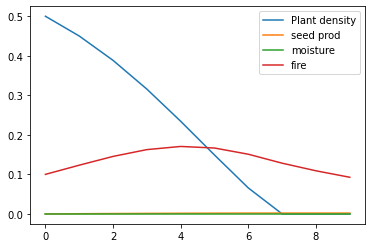

In [9]:
np.random.seed(0)
X = np.random.random((1, 1, 4))

X[0,0] = [0.5, 0, 0.0, 0.1]
# X[0,0,1] = 0
# X[0,0,2] = 1


plants = []
seeds = []
moistures = []
fires = []

for t in range(0, 10):
    plants += [X[0,0,0]]
    seeds += [X[0,0,1]]
    moistures += [X[0,0,2]]
    fires += [X[0,0,3]]
    step_cell(0, 0, X, X, 1)

plt.plot(plants, label='Plant density')
plt.plot(seeds, label='seed prod')
plt.plot(moistures, label='moisture')
plt.plot(fires, label='fire')
plt.legend()
plt.show()

Simulate cell update rules below. In this simulation red pixels are fire, green are plants, blue are moisture

In [10]:
W, H = 64, 64
X = [
    np.zeros((H, W, 4), dtype=np.float32),
    np.zeros((H, W, 4), dtype=np.float32),
]

X[0][:,:,0] = 1
X[0][5,5,3] = 1.0
X[0][0,0,3] = 0.5

# make a divider that the fire can cross in one place
X[0][32,:] *= 0
X[0][32,50,0] = 1

# add some water to a patch
X[0][40:50,20:30,2] = 1

X[1] = np.copy(X[0])

N = 100
FRAMES = np.zeros((N, H, W, 3), dtype=np.uint8)

print(FRAMES[0].shape)

for t in range(N):
    FRAMES[t][:,:,1] = (X[t%2][:,:,0] * 255).astype(np.uint8)
    FRAMES[t][:,:,0] = (X[t%2][:,:,3] * 255).astype(np.uint8)
    FRAMES[t][:,:,2] = (X[t%2][:,:,2] * 255).astype(np.uint8)
    
    for r in range(X[t%2].shape[0]):
        for c in range(X[t%2].shape[1]):
            step_cell(r, c, X[t%2], X[(t+1)%2], 1)

imgs = [Image.fromarray(img).resize((256, 256), resample=Image.NEAREST) for img in FRAMES]
imgs[0].save("fire.gif", save_all=True, append_images=imgs[1:], duration=100, loop=1)            

(64, 64, 3)


![simulation](./fire.gif)

Test out stocastic cell updates to try to make the spread look more organic. Update appears to be much slower though thanks to gif limitations

In [11]:
# W, H = 64, 64
X = [
    np.zeros((H, W, 4), dtype=np.float32),
    np.zeros((H, W, 4), dtype=np.float32),
]

X[0][:,:,0] = 1
X[0][5,5,3] = 1.0
X[0][0,0,3] = 0.5

# make a divider that the fire can cross in one place
X[0][32,:] *= 0
X[0][32,50,0] = 1

# add some water to a patch
X[0][40:50,20:30,2] = 1

X[1] = np.copy(X[0])

N = 10000
FRAMES = np.zeros((N, H, W, 3), dtype=np.uint8)

PIXELS = [(r, c) for c in range(W) for r in range(H)]
random.shuffle(PIXELS)

print(FRAMES[0].shape)

for t in range(N):
    FRAMES[t][:,:,1] = (X[t%1][:,:,0] * 255).astype(np.uint8)
    FRAMES[t][:,:,0] = (X[t%1][:,:,3] * 255).astype(np.uint8)
    FRAMES[t][:,:,2] = (X[t%1][:,:,2] * 255).astype(np.uint8)
    
    for i in range(1):
        r, c = PIXELS[(t + (i * 10)) % len(PIXELS)]
        step_cell(r, c, X[t%1], X[(t+1)%1], 1)

imgs = [Image.fromarray(img).resize((128, 128), resample=Image.NEAREST) for img in FRAMES]
imgs[0].save("stocastic-fire.gif", save_all=True, append_images=imgs[1:], duration=1, loop=1)    

(64, 64, 3)


![simulation](./stocastic-fire.gif)

### Terrain Generation
Try using heatflow equations to create some terrain


[[0. 0.]]
[[0. 0.]]
[[0. 0.]]
[[0.         0.03703704]]
[[0.01851852 0.04938272]]
[[0.03395062 0.06378601]]
[[0.04886831 0.07373114]]
[[0.06129973 0.08224737]]
[[0.07177355 0.0890394 ]]
[[0.08040647 0.09463592]]
[[0.0875212  0.09920442]]
[[0.09336281 0.10295188]]
[[0.09815735 0.10602226]]
[[0.1020898  0.10853973]]
[[0.10531477 0.11060359]]
[[0.10795918 0.11229577]]
[[0.11012747 0.11368318]]
[[0.11190532 0.11482074]]
[[0.11336303 0.11575343]]
[[0.11455823 0.11651817]]
[[0.1155382  0.11714519]]
[[0.11634169 0.11765929]]
[[0.11700049 0.11808081]]
[[0.11754065 0.11842643]]
[[0.11798354 0.1187098 ]]
[[0.11834667 0.11894214]]
[[0.11864441 0.11913265]]
[[0.11888853 0.11928884]]
[[0.11908868 0.11941691]]
[[0.1192528  0.11952191]]
[[0.11938735 0.11960801]]
[[0.11949768 0.1196786 ]]
[[0.11958814 0.11973648]]
[[0.11966231 0.11978393]]
[[0.11972312 0.11982284]]
[[0.11977298 0.11985475]]
[[0.11981386 0.1198809 ]]
[[0.11984738 0.11990235]]
[[0.11987487 0.11991994]]
[[0.1198974  0.11993435]]
[[0.1199

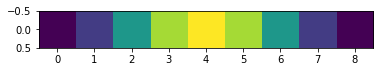

In [37]:
M = np.zeros((1, 9))
# M[1:63,1:63] = (np.random.random((62, 62)) > 0.9).astype(np.float32)

def flow(src, dst):
    k = 1
    for r in range(src.shape[0]):
        for c in range(src.shape[1]):
            patch = src[max(0,r-1):r+2,max(0,c-1):c+2]
            
            if r == 0 and c == 0:
                print(patch)
#             print(patch.size)
#             print(patch)
            neighbors = patch.size
        
            if neighbors == 0:
                continue
    
            laplacian = 0
            for v in patch.flatten():
                laplacian += v - src[r,c]
            laplacian /= neighbors
    
            dst[r,c] += laplacian * k

# M[M.shape[0]//2, M.shape[1]//2] = 1
# M[0, 0] = 1
M[0,4] = 1

sums = []

for _ in range(100):
    sums += [M.sum()]
#     M += (np.random.random((128, 128)) > 0.999).astype(np.float32)
#     M[1:63,1:63] += (np.random.random((62, 62)) > 0.9999).astype(np.float32)
#     r, c = np.random.randint(0, M.shape[0]-1), random.randint(0, M.shape[1]-1)
#     M[r,c] += np.random.random() * 0.5
    flow(M.copy(), M)

plt.imshow(M)
plt.show()

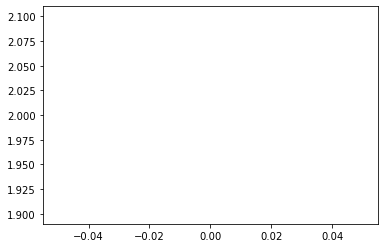

In [25]:
plt.plot(sums)
plt.show()

In [14]:
for i in np.random.random((3,3)):
    print(i)

[0.4236548  0.64589411 0.43758721]
[0.891773   0.96366276 0.38344152]
[0.79172504 0.52889492 0.56804456]
